<img src="eTRIKS.png">

# Introduction

This pipeline aims at providing statistical insights about the datasets without any prior knowledge by carrying out multiple statistical tests on the same data set. Statistical methods test scientific theories when observations, processes or boundary conditions are subject to stochasticity. Carrying out multiple tests on the same data set at the same stage of analysis increases the chance of obtaining at least one invalid result.  However, the gain received from performing statistical methods across whole datasets far offsets this drawback. 

In [1]:
import sys
import gridfs
import numpy
from datetime import datetime
from bson import ObjectId
from pymongo import MongoClient

from pyspark import SparkConf, SparkContext
from pyspark.mllib.classification import LogisticRegressionWithSGD
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.stat import Statistics

from scipy import stats
from scipy.stats import shapiro, anderson, binom_test, f_oneway, pearsonr, chisquare, spearmanr
from Feature import Feature, Summary


sc.addFile("Feature.py")

In [2]:
#####################################
# Functions                         #
#####################################

# Load and parse the data
def parsePoint(feature):
    values = Vectors.dense(feature.featureValues)
    return LabeledPoint(values[0], values[1:])

# Load and parse the data
def simpleParse(line):
    values = [float(x) for x in line.split('\t')]
    return values[1:]

# We return the values contained in the feature object
def parsevaluesFromPatients(feature):
    vector = Vectors.dense(feature.featureValues)
    return vector

def alignVectors(numericalDataList, refVector):
    finalRddPiece = []
    for feature in numericalDataList:
        Xtemp = []
        Ytemp = []
        val = feature.originalValues
        for i in range(len(refVector)):
            if str(refVector[i]) not in 'NA' and str(val[i]) not in 'NA':
                Xtemp.append(float(refVector[i]))
                Ytemp.append(float(val[i]))
        finalRddPiece.append((feature.featureName, Vectors.dense(Xtemp), Vectors.dense(Ytemp)))
        if len(Xtemp) != len(Ytemp):
            print "Xtemp and Ytemp length missmatch!!!!"
    return finalRddPiece

def parseFeatures(line):
    originalVect = [x for x in line.split('\t')]
    # featureValuesStruct = [0 for i in range(len(originalVect) - 1)]
    # for j in range(len(originalVect) - 1):
    #     if originalVect[j+1] in u'NA':
    #         featureValuesStruct[j] = 1
    values = [x for x in line.split('\t') if x not in u'NA']
    return Feature(str(values[0]), values[1:], originalVect[1:])

def countNAs(feature):
    numberofNAs = 0
    val = feature.originalValues
    for i in range(len(val)):
        if val[i] in u'NA':
            numberofNAs+=1
    return (feature.featureName, numberofNAs)


def calculateShapiroThreshold(numberOfElements):
    # Those numbers for W are from http://www.statistics4u.info/fundstat_eng/ee_shapiro_wilk_test.html
    if numberOfElements == 5:
        return 0.762
    elif numberOfElements == 6:
        return 0.788
    elif numberOfElements == 7:
        return 0.803
    elif numberOfElements == 8:
        return 0.818
    elif numberOfElements == 9:
        return 0.829
    elif numberOfElements == 10:
        return 0.842
    elif numberOfElements == 11:
        return 0.850
    elif numberOfElements == 12:
        return 0.859
    elif numberOfElements == 13:
        return 0.866
    elif numberOfElements == 14:
        return 0.874
    elif numberOfElements == 15:
        return 0.881
    elif numberOfElements == 16:
        return 0.887
    elif numberOfElements == 17:
        return 0.892
    elif numberOfElements == 18:
        return 0.897
    elif numberOfElements == 19:
        return 0.901
    elif 25 > numberOfElements >= 20:
        return 0.905
    elif 30 > numberOfElements >= 25:
        return 0.918
    elif 35 > numberOfElements >= 30:
        return 0.927
    elif 40 > numberOfElements >= 35:
        return 0.934
    elif 50 > numberOfElements >= 40:
        return 0.940
    elif numberOfElements >= 50:
        return 0.947

In [3]:
#####################################
# general Statistics                 #
#####################################

def do_generalStatistics(data):
    summary = dict()
    #mat = data.map(parsevaluesFromPatients)
    numberOfNAs = data.map(countNAs).collect()
    #summary = Statistics.colStats(mat)
    summary = Summary(numberOfNAs)
    return summary


#####################################
# Categorical methods               #
#####################################

def chiSqTest(vect):
    classes = list(set(vect))
    obs = []
    print classes
    if len(classes) > 1:
        for i in range(len(classes)):
            obs.append(vect.count(classes[i]))
        chiSqTest = chisquare(obs)
    else:
        chiSqTest = (0, 0)
    return chiSqTest

def do_chiSquare(categoricalData):
    # Compute the ChiSquareTest
    independenceTestResult = categoricalData.map(lambda f: chiSqTest(f.featureValues))
    return independenceTestResult

def computeSTD(f):
    std = numpy.std(f.featureValues)
    roundedStd = numpy.around(std,2)
    return (roundedStd, [f.featureName, f.featureValues])

def anovaTest(values):
    features = [x[0] for x in values]
    values = [x[1] for x in values]
    anovaTest = f_oneway(*values)
    return features, anovaTest

def do_onewayANOVA(normalData):
    #  Tests the null hypothesis that samples in two or more groups are drawn from populations with the same mean values
    anova = normalData.map(computeSTD).groupByKey().map(lambda (k, v): (k, anovaTest(v))).collect()
    return anova


In [4]:
#####################################
# Binay methods                     #
#####################################

def reshapeForBinomialTest(f):
    featuresList = f.featureValues
    classes = list(set(featuresList))
    classesCount = [0, 0]
    if len(classes) == 2:
        classesCount[0] = featuresList.count(classes[0])
        classesCount[1] = featuresList.count(classes[1])
    else:
        tmp = []
        for i in range(len(classes)):
            tmp.append(featuresList.count(classes[i]))
        orderedTmp = sorted(tmp)
        classesCount[0] = orderedTmp[0]
        classesCount[1] = orderedTmp[1]

    return (f.featureName, classesCount)


def do_bionomialTest(binomialData):
    # This is an exact, two-sided test of the null hypothesis that the probability of success in a Bernoulli experiment is p
    nullHypothesis = binomialData.map(reshapeForBinomialTest).map(lambda f: (f[0], binom_test(f[1])))
    return nullHypothesis


In [5]:
#####################################
# Numerical methods                 #
#####################################

#####  Test non normal Distributions using KolmogorovSmirnov test (KS test or KS test) ######
def do_ks_distibution(l, dist):
    ks_data = numpy.asarray(l.featureValues)
    kstest = stats.kstest(ks_data, dist, args=(min(ks_data), max(ks_data)))
    if kstest[1] < 0.05:
        l.distribution = dist
    return l


#####  Test Normal Distribution ######
def do_normality(l, dist, confidenceNormality):
    l_shapiro = do_shapiro(l)
    l_sa = do_anderson(l_shapiro, dist)
    l_final = applyNormality(l_sa, confidenceNormality)
    return l_final

def do_shapiro(l):
    # The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution.
    shapiroData = l.featureValues
    l.normality.shapiro = shapiro(shapiroData)
    return l


def do_anderson(l, dist):
    # The Anderson-Darling test is a modification of the Kolmogorov-Smirnov test kstest for the null hypothesis that a sample is drawn from a population that follows a particular distribution.
    andersonData = l.featureValues
    l.normality.anderson = anderson(andersonData, dist)
    return l


def applyNormality(f, confidenceNormality):
    # We have to be careful because we have the Inf case
    isAndersonNormal = f.normality.anderson[0] < f.normality.anderson[1][2]
    # I get the right threshold for W according to the length of the vector
    shapiroThreshold = calculateShapiroThreshold(len(f.featureValues))
    print f.normality
    print f.normality.shapiro[0] > shapiroThreshold
    print isAndersonNormal and f.normality.shapiro[0] > shapiroThreshold
    # We select a 95% threshold for rejecting the null hypothesis
    if isAndersonNormal and f.normality.shapiro[0] > shapiroThreshold:
        f.distribution = "normal"
    else:
        f.distribution = "unknown"
    return f

def corr_pearson(tuples):
    correlationValues=[]
    for values in tuples:
        featureName = values[0]
        X = values[1]
        Y = values[2]
        if len(X) > 2 and len(set(X)) > 1 and len(set(Y)) > 1:
            corrValue = pearsonr(X, Y)
        else:
            corrValue = (0, 0)
        correlationValues.append((featureName, corrValue))
    return correlationValues

def corr_spearman(tuples):
    correlationValues=[]
    for values in tuples:
        featureName = values[0]
        X = values[1]
        Y = values[2]
        if len(X) > 2 and len(set(X)) > 1 and len(set(Y)) > 1:
            corrValue = spearmanr(X, Y)
        else:
            corrValue = (0, 0)
        correlationValues.append((featureName, corrValue))
    return correlationValues

def buildMatrix(f):
    return f.featureName, f.originalValues

def getFeatureNames(f):
    return f.featureName

def do_correlation(matrices, typeOfCorrelation):
    # Build the matrix
    #correlationResults = corr(matrices, typeOfCorrelation)
    if typeOfCorrelation is 'pearson':
        correlationResults = matrices.map(lambda tuple: ( tuple[0], corr_pearson(tuple[1])))
    elif typeOfCorrelation is 'spearman':
        correlationResults = matrices.map(lambda tuple: ( tuple[0], corr_spearman(tuple[1])))
    else:
        correlationResults = "Unknown Corr"
    return correlationResults

def buildMatrices(numericalDataList, mat):
    familyOfMatrices = mat.map(lambda l: (l[0], alignVectors(numericalDataList, l[1])))
    return familyOfMatrices

def do_logisticRegression(data):
    parsedData = data.map(parsePoint)
    # Build the model
    model = LogisticRegressionWithSGD.train(parsedData)
    # Evaluating the model on training data
    labelsAndPreds = parsedData.map(lambda p: (p.label, model.predict(p.features)))
    trainErr = labelsAndPreds.filter(lambda (v, p): v != p).count() / float(parsedData.count())
    return trainErr

def printDistribution(f):
    print str(f) + " , " + str(f.featureValues)


def rebuildVector(correlationsList,positions,listLength):
        newVect = numpy.zeros(listLength)
        for i in range(len(correlationsList)):
            val = correlationsList[i][1][0] #*10 we could multiply by 10 to highlight the heatmap better
            if(val<0.001):
               newVect[positions[correlationsList[i][0]]] = 0
            else:
               newVect[positions[correlationsList[i][0]]] = val
        #return numpy.asarray(newVect)
        return newVect


# MAIN

In [6]:
#####################################
# main program                      #
#####################################
fileDirectory = ""
fileName = ""
modeToUse = 0
#dataFile = ""

mongoURL = '146.169.32.148:27017'
confidenceNormality = 1.0
collectionToRetrieve = "ubiopred"
dataType = "Clinical"

studyName = "GSE3113"

In [7]:
db_studies = MongoClient('mongodb://' + mongoURL + '/').studies
gtCollection = db_studies[collectionToRetrieve]

data = sc.parallelize(list(gtCollection.find({'DataType': dataType}))) \
        .map(lambda l: l["FeatureName"] + '\t' + l["FeatureValue"])

# We extract the numeric values for shapiro
features = data.map(parseFeatures)

numericalData = features.filter(lambda f: f.featureFamily is "Numerical").cache()
binaryData = features.filter(lambda f: f.featureFamily is "Binary").cache()
categoricalData = features.filter(lambda f: f.featureFamily is "Categorical").cache()
features.unpersist()

# We compute the normality tests
normalizedData = numericalData.map(lambda f: do_normality(f, 'norm', confidenceNormality))
normalData = normalizedData.filter(lambda f: f.distribution is "normal")

unknownData = normalizedData.filter(lambda f: f.distribution is "unknown")

dataCount = {"BinaryDataCount": str(binaryData.count()),
            "CategoricalDataCount":str(categoricalData.count()),
            "NumericalDataCount": str(numericalData.count()),
            "NormalDataCount":str(normalData.count()),
            "UnknownDataCount": str(unknownData.count())}

print "/***********************************************/"
print "Number of binary data " + dataCount["BinaryDataCount"]
print "Number of categorical data " + dataCount["CategoricalDataCount"]
print "Number of numerical data " + dataCount["NumericalDataCount"]
print "Number of normal data " + dataCount["NormalDataCount"]
print "Number of unknown data " + dataCount["UnknownDataCount"]
print "/***********************************************/"

/***********************************************/
Number of binary data 2238
Number of categorical data 285
Number of numerical data 1854
Number of normal data 339
Number of unknown data 1515
/***********************************************/


# Binary Data
The binomial test is an exact, two-sided test of the null hypothesis that the probability of success in a Bernoulli experiment is p (here p=0.5). If we reject the null hypothesis then, same as for ANOVA and chi squared test, we get some insight on a possible patient stratification.

In [9]:
#####################################
# Binomial test                     #
#####################################
binaryPValues = do_bionomialTest(binaryData)

print binaryPValues.first()

('\\Exacerbations\\Screening\\incident 2\\Increase of dose of oral glucocorticoids less than 3 days', 1.5995706288742762e-72)


# Categorical data
The chi-squared test is used to determine whether there is a significant difference between the expected frequencies and the observed frequencies in one or more categories. If one of the categories stands out, we can then assume that the two clusters can be used as an unbiased start for the patient stratification.

In [10]:
#####################################
# ChiSquare test                    #
#####################################
independenceTestResult = do_chiSquare(categoricalData)

print independenceTestResult.first()

(394.13207547169804, 4.1320534438775458e-85)


# Numerical data

In [ ]:
mat = sc.parallelize(numericalData.map(buildMatrix).collect())
numericalDataList = numericalData.collect()
matrices = buildMatrices(numericalDataList, mat)

pearson_correlation = do_correlation(matrices, "pearson").cache()

pearson_correlation_labels = pearson_correlation.map(lambda l: str(l[0])).take(15)
positions = dict()

for i in range(15):
    positions[pearson_correlation_labels[i]] = i

matTemp = []
matTemp = pearson_correlation.map(lambda l: rebuildVector(l[1], positions, len(pearson_correlation_labels))).collect()

In [ ]:
 matrice=numpy.asarray(matTemp)
#matrice=numpy.asarray(toto)
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

# Plot it out
fig, ax = plt.subplots()
heatmap = ax.pcolor(matrice, cmap=plt.cm.Blues, alpha=0.8)
# Format
fig = plt.gcf()
fig.set_size_inches(100, 100)
# turn off the frame
ax.set_frame_on(False)
# put the major ticks at the middle of each cell
ax.set_yticks(numpy.arange(matrice.shape[0]) + 0.5, minor=False)
ax.set_xticks(numpy.arange(matrice.shape[1]) + 0.5, minor=False)
# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()
# note I could have used nba_sort.columns but made "labels" instead
ax.set_xticklabels(pearson_correlation_labels, minor=False)
ax.set_yticklabels(pearson_correlation_labels, minor=False)
# rotate the
plt.xticks(rotation=90)
ax.grid(False)
# Turn off all the ticks
ax = plt.gca()
for t in ax.xaxis.get_major_ticks():
    t.tick1On = False
    t.tick2On = False
for t in ax.yaxis.get_major_ticks():
    t.tick1On = False
    t.tick2On = False
    
#fig.show()

<img src="heatmap.png">

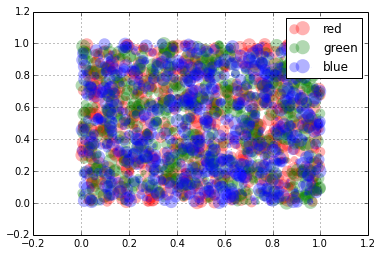

In [9]:
%matplotlib inline
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from numpy.random import rand


for color in ['red', 'green', 'blue']:
    n = 750
    x, y = rand(2, n)
    scale = 200.0 * rand(n)
    plt.scatter(x, y, c=color, s=scale, label=color,
                alpha=0.3, edgecolors='none')

plt.legend()
plt.grid(True)

plt.show()

<img src="spark-logo.png"> <img src="pythonlogo.jpg">

That's all Floks